In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import datetime
import time
import warnings
from sklearn.model_selection import train_test_split
from model import *
from rgf.sklearn import RGFClassifier
import xgbfir
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm  import LGBMClassifier

In [2]:
%load_ext autoreload
%autoreload 2
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
# 关闭 SettingWithCopyWarning 
pd.set_option('mode.chained_assignment', None)

In [3]:
df = pd.read_csv('data.csv', encoding='gbk')

In [4]:
df.shape

(4754, 90)

In [5]:
df.head()

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,...,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
1,10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
2,12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,...,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
3,13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,...,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
4,14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,...,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0


In [6]:
x = df.drop('status', axis=1)
y = df['status']

# 数据类型分析

In [7]:
train_test = x

In [8]:
train_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Columns: 89 entries, Unnamed: 0 to loans_latest_day
dtypes: float64(70), int64(12), object(7)
memory usage: 3.2+ MB


原数据中数值型特征有 82 个，字符串类型特征有 7 个，多数特征缺失值不是特别多，student_feature 缺失值较多。

In [9]:
train_test.describe()

,Unnamed: 0,custid,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
count,4754.000000,4.754000e+03,4752.000000,4752.000000,4754.000000,4751.000000,4752.000000,4752.000000,4752.000000,4746.000000,...,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4450.000000,4457.000000
mean,6008.414178,1.690993e+06,0.021806,0.901294,1940.197728,14.160674,0.804411,0.365425,17.502946,29.029920,...,3390.038142,1820.357864,9187.009199,76.042630,4.732331,5.227507,16153.690823,8007.696881,24.112809,55.181512
std,3452.071428,1.034235e+06,0.041527,0.144856,3923.971494,694.180473,0.196920,0.170196,4.475616,22.722432,...,1474.206546,583.418291,7371.257043,14.536819,2.974596,3.409292,14301.037628,5679.418585,37.725724,53.486408
min,5.000000,1.140000e+02,0.000000,0.000000,0.000000,0.000000,0.120000,0.033000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000
25%,3106.000000,7.593358e+05,0.010000,0.880000,0.000000,0.615000,0.670000,0.233000,15.000000,16.000000,...,2300.000000,1535.000000,4800.000000,77.000000,2.000000,3.000000,7800.000000,4737.000000,5.000000,10.000000
50%,6006.500000,1.634942e+06,0.010000,0.960000,500.000000,0.970000,0.860000,0.350000,17.000000,23.000000,...,3100.000000,1810.000000,7700.000000,79.000000,4.000000,5.000000,13800.000000,7050.000000,14.000000,36.000000
75%,8999.000000,2.597905e+06,0.020000,0.990000,2000.000000,1.600000,1.000000,0.480000,20.000000,32.000000,...,4300.000000,2100.000000,11700.000000,80.000000,7.000000,7.000000,20400.000000,10000.000000,24.000000,91.000000
max,11992.000000,4.004694e+06,1.000000,1.000000,68000.000000,47596.740000,1.000000,0.941000,42.000000,285.000000,...,10000.000000,6900.000000,87100.000000,87.000000,18.000000,20.000000,266400.000000,82800.000000,360.000000,323.000000


In [10]:
train_test.describe(include='O')

,trade_no,bank_card_no,reg_preference_for_trad,source,id_name,latest_query_time,loans_latest_time
count,4754,4754,4752,4754,4478,4450,4457
unique,4754,1,5,1,4309,207,232
top,20180507122406820000000023086536,卡号1,一线城市,xs,李杰,2018-04-14,2018-05-03
freq,1,4754,3403,4754,5,423,134


In [11]:
y.mean()

0.2509465713083719

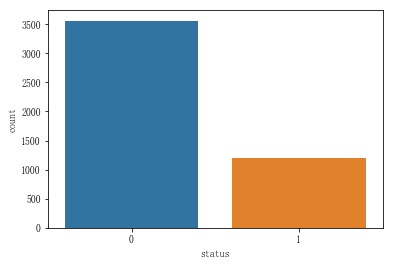

In [12]:
sns.countplot(y)

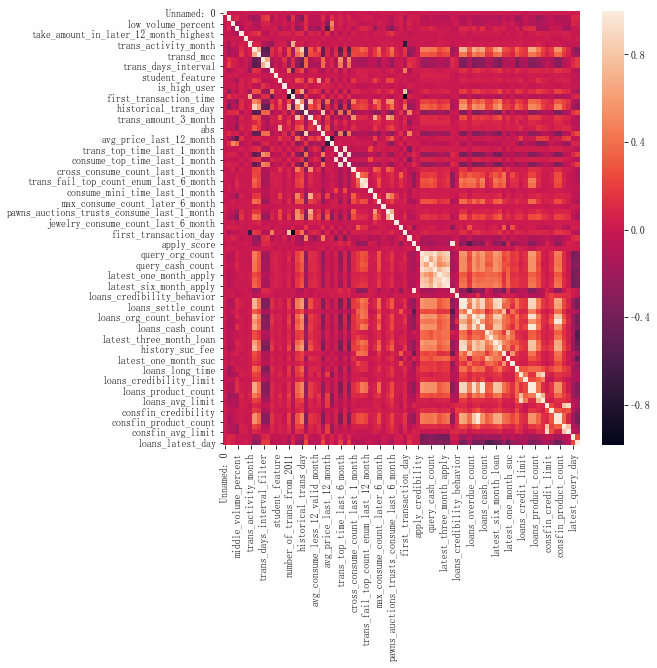

In [13]:
corr_mat = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_mat)

相关性较强的特征集中在关于下半部分

# 原数据简单处理的结果

In [14]:
dataset01 = train_test.drop(["custid","trade_no","bank_card_no","id_name","first_transaction_time","latest_query_time","loans_latest_time","source"],axis=1)

In [15]:
# 用众数填充缺失值
for c in dataset01.columns:
    dataset01.loc[dataset01[c].isnull(), c] = dataset01[c].mode()[0]

In [16]:
city_map = {'一线城市':1, '二线城市':2, '三线城市':3, '其他城市':4, '境外':0}
dataset01['reg_preference_for_trad'] = dataset01['reg_preference_for_trad'].map(city_map)
dataset01["student_feature"] = dataset01["student_feature"].replace([2],[0])

In [17]:
dataset01 = dataset01.convert_objects(convert_numeric=True)

C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [18]:
def print_result(model, x_train, y_train, x_test):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_train_proba = model.predict_proba(x_train)[:, 1]
    print('----Training Report----')
    model.report(y_train, y_train_pred, y_train_proba)
    print('----Test Report----')
    y_test_pred = model.predict(x_test)
    y_test_proba = model.predict_proba(x_test)[:, 1]
    model.report(y_test, y_test_pred, y_test_proba)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(dataset01, y, test_size=0.2, random_state=666)
x_train_scale = minmax_scale(x_train)
x_test_scale = minmax_scale(x_test)

In [20]:
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train_scale, y_train, x_test_scale)

----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.79      0.98      0.88      2863
          1       0.82      0.22      0.35       940

avg / total       0.80      0.80      0.75      3803

SVC AUC：
 0.8076255378601526
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.76      0.99      0.86       698
          1       0.80      0.16      0.26       253

avg / total       0.77      0.77      0.70       951

SVC AUC：
 0.7789307677497537


In [21]:
xgbClassifier = XGBClassifier()
xgbmodel = SklearnWrapper(xgbClassifier)
print_result(xgbmodel, x_train, y_train, x_test)

----Training Report----
XGBClassifier report：
              precision    recall  f1-score   support

          0       0.85      0.98      0.91      2863
          1       0.86      0.47      0.61       940

avg / total       0.85      0.85      0.83      3803

XGBClassifier AUC：
 0.9034508512867769
----Test Report----
XGBClassifier report：
              precision    recall  f1-score   support

          0       0.80      0.95      0.87       698
          1       0.69      0.34      0.46       253

avg / total       0.77      0.78      0.76       951

XGBClassifier AUC：
 0.7894775586939533


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 无关特征删除

## 类别特征

### bank_card_no 和 source

bank_card_no 和 source unique 等于 1，删除

In [22]:
train_test.drop(['bank_card_no', 'source'], axis=1, inplace=True)

### trade_no

In [23]:
train_test['trade_no'].head(10)

0    20180507115231274000000023057383
1    20180507121002192000000023073000
2    20180507125159718000000023114911
3    20180507121358683000000388283484
4    20180507115448545000000388205844
5    20180507121233054000000388275132
6    20180507121931540000000388298915
7    20180507124659235000000023105807
8    20180507115855621000000388224458
9    20180504155156296000000021138084
Name: trade_no, dtype: object

In [24]:
def parse_trade_no(array):
    lst = [array[:4], array[4:6], array[6:8], array[-10:]]
    return lst

In [25]:
tradeno_df = pd.DataFrame(train_test['trade_no'].apply(parse_trade_no).values.tolist(), columns=['tradeno_year', 'tradeno_month', 'tradeno_day', 'tradeno_id'])

In [26]:
tradeno_df.describe()

,tradeno_year,tradeno_month,tradeno_day,tradeno_id
count,4754,4754,4754,4754
unique,1,1,3,4754
top,2018,05,07,0381395001
freq,4754,4754,3682,1


In [27]:
tradeno_df['tradeno_day'].value_counts()

07    3682
04    1062
08      10
Name: tradeno_day, dtype: int64

trade_no 字段像个 id 字段，假设前 8 位是年月日信息，可以看出 trade_no 均是在 2018 年 5 月份，tradeno_id 各不相同，保留 tradeno_day，其他的信息删除。

In [28]:
train_test = pd.concat((train_test.drop('trade_no', axis=1), tradeno_df['tradeno_day']), axis=1)

In [29]:
train_test['tradeno_day'].value_counts()

07    3682
04    1062
08      10
Name: tradeno_day, dtype: int64

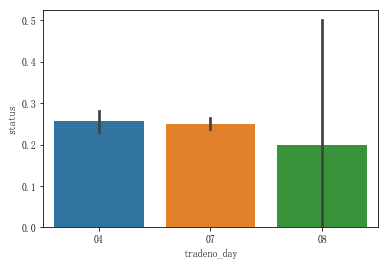

In [30]:
sns.barplot(data=pd.concat((train_test.loc[:x.shape[0]], y), axis=1), x='tradeno_day', y='status')

### id_name

找出出现次数比较多的人名，看看逾期率

In [31]:
idname_count=train_test['id_name'].value_counts()
idname_count = idname_count[idname_count>=4]
idn_df = train_test[train_test['id_name'].isin(idname_count.index)]

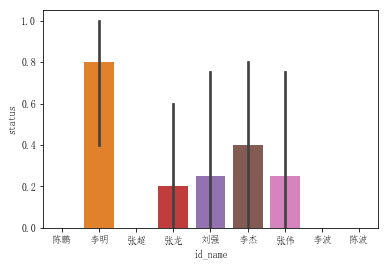

In [32]:
sns.barplot(data=pd.concat((idn_df, y), axis=1), x='id_name', y='status')

李明这个人逾期率挺高的，重点提出来作为类别变量

In [33]:
train_test['is_Li_Ming'] = (df['id_name'] == '李明').apply(int)
train_test.drop('id_name', inplace=True, axis=1)

## 数值特征

In [34]:
value_cols = train_test.describe().columns

In [35]:
train_test[value_cols].nunique().describe()

count      83.000000
mean      486.650602
std      1051.987056
min         2.000000
25%        25.000000
50%        65.000000
75%       222.500000
max      4754.000000
dtype: float64

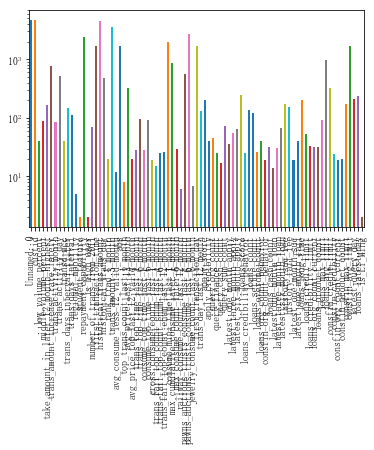

In [36]:
train_test[value_cols].nunique().plot(kind='bar', logy=True)

In [37]:
print('数值特征 unique < 10 个数：', len(train_test[value_cols].columns[train_test[value_cols].nunique()<10]))
print('数值特征 unique < 20 个数：', len(train_test[value_cols].columns[train_test[value_cols].nunique()<20]))
print('数值特征 unique < 30 个数：', len(train_test[value_cols].columns[train_test[value_cols].nunique()<30]))

数值特征 unique < 10 个数： 7
数值特征 unique < 20 个数： 15
数值特征 unique < 30 个数： 27


In [38]:
print('全部为 unique 的特征', train_test[value_cols].columns[train_test[value_cols].nunique()==len(train_test)])

全部为 unique 的特征 Index(['Unnamed: 0', 'custid'], dtype='object')


从 unique 数量来讲，没有 unique == 1 的情况，先不予删除。

### custid

custid 范围中 100~400W，如果假设注册越早，id 越小，看一下 id 大小与逾期率的关系。

In [39]:
custid_range = [1, 1e4, 1e5, 1e6, 2.5e6, 5e6]

In [40]:
train_test['cust_id_bin'] = pd.cut(train_test['custid'], bins=custid_range, labels=[str(i) for i in custid_range][:-1]).astype('float')
train_test.drop('custid', axis=1, inplace=True)

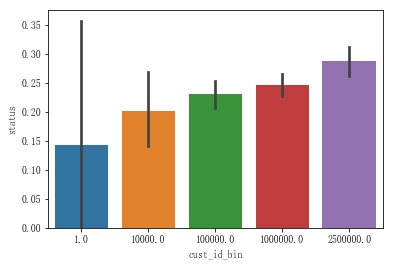

In [41]:
sns.barplot(data=pd.concat((train_test, y),axis=1), x='cust_id_bin', y='status')

正如猜想的一样，id 越小，逾期率越低，可能原因是越最近注册的，是新用户，紧急用钱，越可能逾期。先保留 id 这个特征。

### Unnamed: 0

In [42]:
sum(train_test['Unnamed: 0'].diff(1)>0)

4753

In [43]:
len(train_test)

4754

Unnamed: 0 这个特征数值是递增的，删除

In [44]:
train_test.drop('Unnamed: 0', axis=1, inplace=True)

In [45]:
train_test.describe(include='O')

,reg_preference_for_trad,latest_query_time,loans_latest_time,tradeno_day
count,4752,4450,4457,4754
unique,5,207,232,3
top,一线城市,2018-04-14,2018-05-03,07
freq,3403,423,134,3682


In [46]:
dataset02 = train_test.drop(["latest_query_time","loans_latest_time"], axis=1)
# 用众数填充缺失值
for c in dataset02.columns:
    dataset02.loc[dataset02[c].isnull(), c] = dataset02[c].mode()[0]
dataset02["student_feature"] = dataset02["student_feature"].replace([2],[0])
dataset02['reg_preference_for_trad'] = dataset02['reg_preference_for_trad'].map(city_map)
dataset02 = dataset02.convert_objects(convert_numeric=True)
dataset02 = minmax_scale(dataset02)
x_train, x_test, y_train, y_test = train_test_split(dataset02, y, test_size=0.2, random_state=666)
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train, y_train, x_test)

C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.79      0.99      0.88      2863
          1       0.82      0.20      0.33       940

avg / total       0.80      0.79      0.74      3803

SVC AUC：
 0.8093180787895453
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.77      0.98      0.86       698
          1       0.78      0.19      0.31       253

avg / total       0.77      0.77      0.72       951

SVC AUC：
 0.7988776515623408


# 数据类型转换

In [47]:
train_test.describe(include='O')

,reg_preference_for_trad,latest_query_time,loans_latest_time,tradeno_day
count,4752,4450,4457,4754
unique,5,207,232,3
top,一线城市,2018-04-14,2018-05-03,07
freq,3403,423,134,3682


## reg_preference_for_trad

In [48]:
train_test['reg_preference_for_trad'].value_counts()

一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

城市之间存在大小差别，采用自然数编码

In [49]:
city_map = {'一线城市':1, '二线城市':2, '三线城市':3, '其他城市':0, '境外':5}

In [50]:
train_test['reg_preference_for_trad'] = train_test['reg_preference_for_trad'].map(city_map)

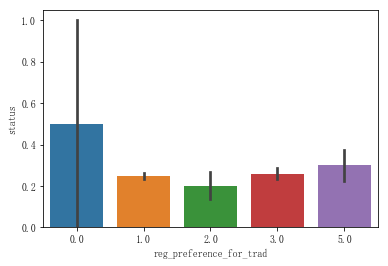

In [51]:
sns.barplot(data=pd.concat((train_test, y), axis=1), x='reg_preference_for_trad', y='status')

## tradeno_day

In [52]:
train_test['tradeno_day'] = train_test['tradeno_day'].astype('int')

In [53]:
train_test.describe(include='O')

,latest_query_time,loans_latest_time
count,4450,4457
unique,207,232
top,2018-04-14,2018-05-03
freq,423,134


# 缺失值处理

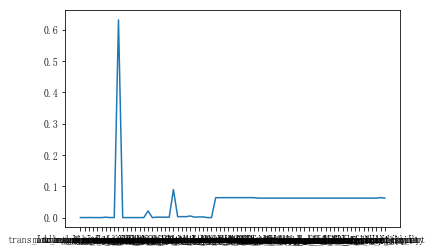

In [54]:
nan_prop = train_test.isnull().sum(axis=0)[train_test.isnull().sum(axis=0)!=0]/train_test.shape[0]
plt.plot(nan_prop)

## 缺失值处理

缺失值大概分成三类，比例在 60%，5%~10%, 1% 左右

### 缺失比例>10%

只有一列，转换成 one-hot 编码

In [55]:
nan100 = train_test[train_test.columns[train_test.isnull().sum(0)/train_test.shape[0]>0.1]]

In [56]:
nan100['student_feature'].value_counts()

1.0    1754
2.0       2
Name: student_feature, dtype: int64

In [57]:
def parse_student_feature(array):
    lst = [0, 0]
    if array == 1:
        lst[0] = 1
    elif array == 2:
        lst[1] = 1
    return lst

In [58]:
stu_featdf = pd.DataFrame(train_test['student_feature'].apply(parse_student_feature).values.tolist(
), columns=['student_feat_1', 'student_feat_2'])

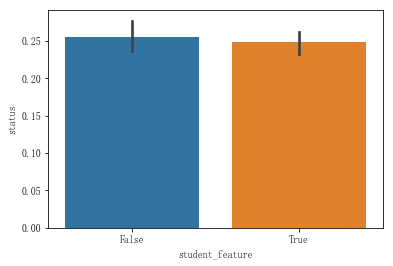

In [59]:
sns.barplot(data=pd.concat((train_test['student_feature'].isnull(), y), axis=1), x='student_feature', y='status')

student 是否缺失与逾期率相差不大

In [60]:
train_test = pd.concat((train_test.drop('student_feature', axis=1), stu_featdf), axis=1)

In [61]:
# 用众数填充剩下的缺失值
for c in train_test.columns:
    train_test.loc[train_test[c].isnull(), c] = train_test[c].mode()[0]

In [62]:
dataset03 = train_test.drop(["latest_query_time","loans_latest_time"], axis=1)

dataset03 = dataset03.convert_objects(convert_numeric=True)
dataset03 = minmax_scale(dataset03)
x_train, x_test, y_train, y_test = train_test_split(dataset03, y, test_size=0.2, random_state=666)
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train, y_train, x_test)

C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.79      0.99      0.88      2863
          1       0.83      0.21      0.33       940

avg / total       0.80      0.79      0.74      3803

SVC AUC：
 0.809110737880961
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.77      0.98      0.86       698
          1       0.78      0.20      0.32       253

avg / total       0.78      0.77      0.72       951

SVC AUC：
 0.7991098225307769


## 时间特征

In [63]:
time_feat = train_test[['latest_query_time', 'loans_latest_time']]

In [64]:
train_test['latest_query_time_year'] = pd.to_datetime(train_test['latest_query_time']).dt.year
train_test['latest_query_time_month'] = pd.to_datetime(train_test['latest_query_time']).dt.month
train_test['latest_query_time_dayofyear'] = pd.to_datetime(train_test['latest_query_time']).dt.dayofyear
train_test['latest_query_time_dayofweek'] = pd.to_datetime(train_test['latest_query_time']).dt.dayofweek
train_test['latest_query_time_weekday'] =(train_test['latest_query_time_dayofweek']<=5).apply(int)

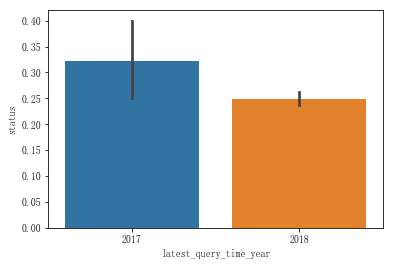

In [65]:
sns.barplot(data=pd.concat(
    (train_test['latest_query_time_year'], y), axis=1), x='latest_query_time_year', y='status')

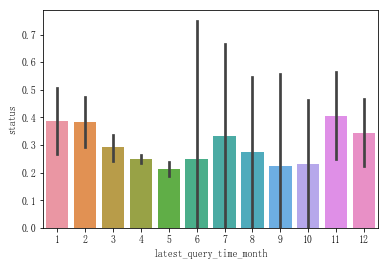

In [66]:
sns.barplot(data=pd.concat(
    (train_test['latest_query_time_month'], y), axis=1), x='latest_query_time_month', y='status')

In [67]:
train_test['loans_latest_time_year'] = pd.to_datetime(train_test['loans_latest_time']).dt.year
train_test['loans_latest_time_month'] = pd.to_datetime(train_test['loans_latest_time']).dt.month
train_test['loans_latest_time_dayofyear'] = pd.to_datetime(train_test['loans_latest_time']).dt.dayofyear
train_test['loans_latest_time_dayofweek'] = pd.to_datetime(train_test['loans_latest_time']).dt.dayofweek
train_test['loans_latest_time_weekday'] =(train_test['loans_latest_time_dayofweek']<=5).apply(int)

In [68]:
train_test['interval_query_loan_time'] = pd.to_datetime(
    train_test['latest_query_time'])-pd.to_datetime(train_test['loans_latest_time'])
train_test['interval_query_loan_time'] = train_test['interval_query_loan_time'].apply(lambda x:x.days)

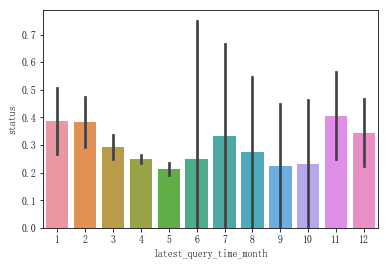

In [69]:
sns.barplot(data=pd.concat(
    (train_test['latest_query_time_month'], y), axis=1), x='latest_query_time_month', y='status')

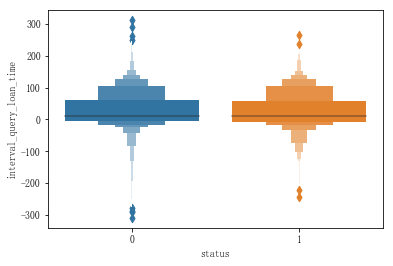

In [70]:
sns.boxenplot(data=pd.concat(
    (train_test['interval_query_loan_time'], y), axis=1), y='interval_query_loan_time', x='status')

In [71]:
train_test.drop(['loans_latest_time', 'latest_query_time'], axis=1, inplace=True)

In [72]:
dataset04 = train_test

dataset04 = dataset04.convert_objects(convert_numeric=True)
dataset04 = minmax_scale(dataset04)
x_train, x_test, y_train, y_test = train_test_split(dataset04, y, test_size=0.2, random_state=666)
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train, y_train, x_test)

C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.79      0.99      0.88      2863
          1       0.82      0.20      0.32       940

avg / total       0.80      0.79      0.74      3803

SVC AUC：
 0.8096134838474743
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.77      0.98      0.86       698
          1       0.76      0.20      0.31       253

avg / total       0.77      0.77      0.72       951

SVC AUC：
 0.796323770909544


# 特征工程

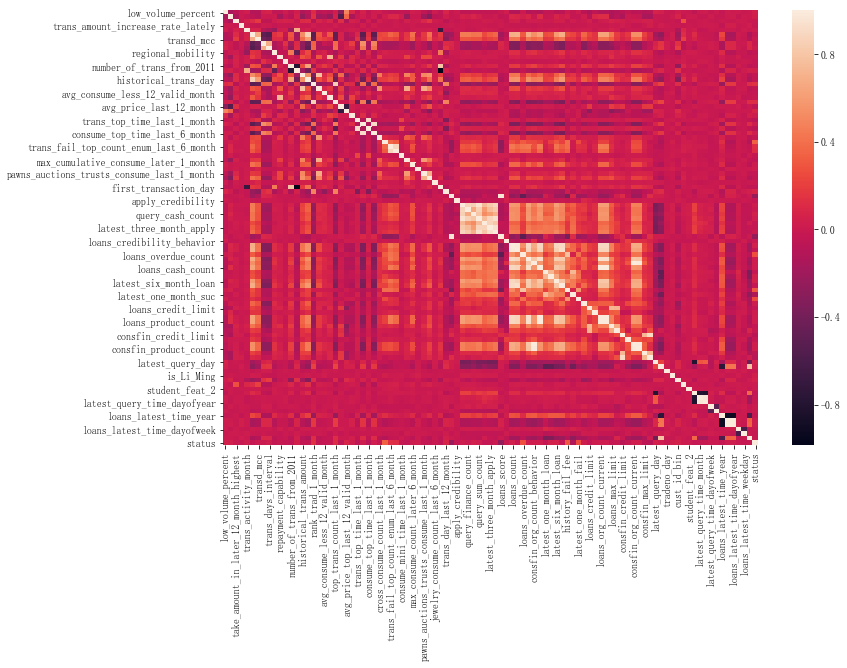

In [73]:
corr_mat = pd.concat((train_test, y), axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat)

In [74]:
corr_mat.loc['status'].sort_values(ascending=False)

status                                        1.000000
trans_fail_top_count_enum_last_1_month        0.333339
history_fail_fee                              0.306273
loans_overdue_count                           0.266961
latest_one_month_fail                         0.248837
rank_trad_1_month                             0.146643
trans_fail_top_count_enum_last_6_month        0.134436
trans_fail_top_count_enum_last_12_month       0.118328
top_trans_count_last_1_month                  0.117299
trans_day_last_12_month                       0.078974
avg_price_top_last_12_valid_month             0.071259
latest_six_month_loan                         0.060227
latest_query_day                              0.057419
cust_id_bin                                   0.054846
query_cash_count                              0.053036
low_volume_percent                            0.051911
latest_three_month_loan                       0.051411
loans_count                                   0.046899
is_Li_Ming

## 相关性强的特征

### 类别特征

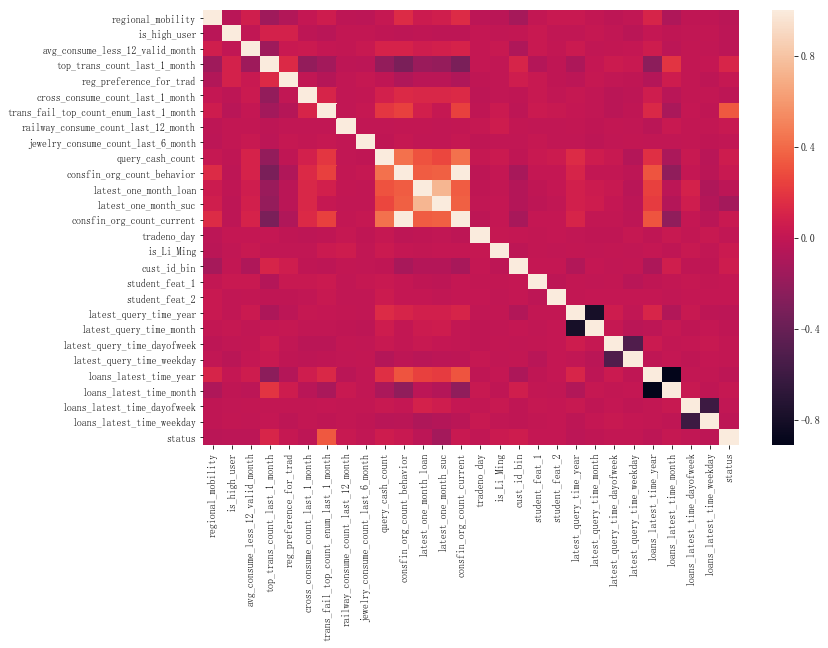

In [75]:
# nunique 小于 20 的 相关性系数
cat_cols = train_test.nunique()[train_test.nunique()<20].index
cat_train_test = train_test[cat_cols]
corr_mat = pd.concat((cat_train_test, y), axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat)

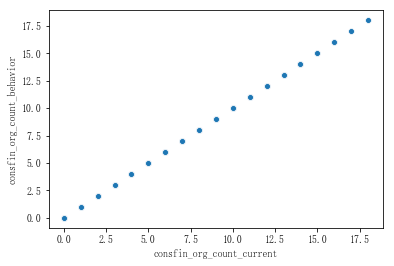

In [76]:
sns.scatterplot(train_test['consfin_org_count_current'], train_test['consfin_org_count_behavior'])

consfin_org_count_current 和 consfin_org_count_behavior 相关性系数非常高，数据相同，删除一个特征，  
并没有发现与 status 相关系数特别高的类别特征

In [77]:
train_test.drop('consfin_org_count_current', axis=1, inplace=True)

### 数值特征

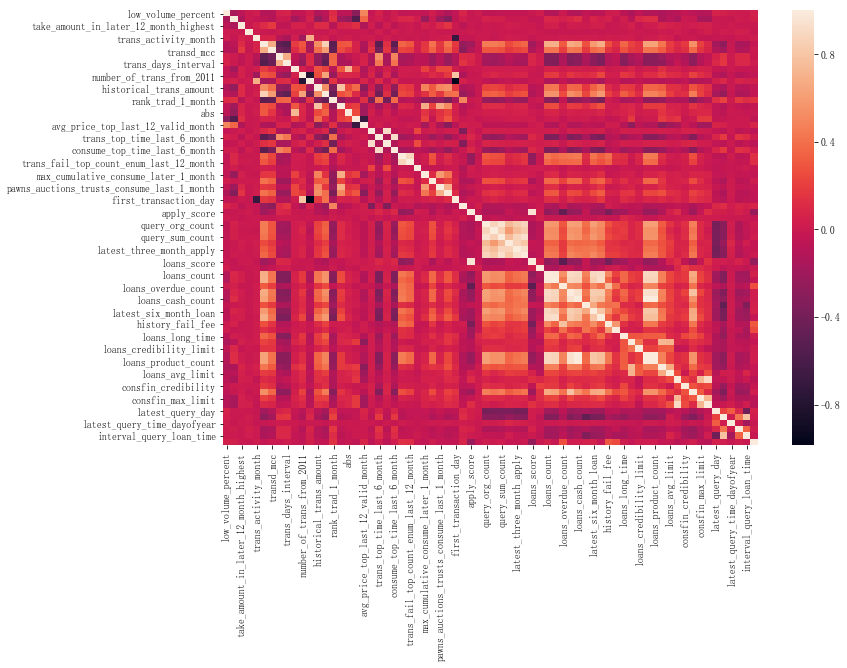

In [78]:
# nunique 大于 20 的 相关性系数
cat_cols = train_test.nunique()[train_test.nunique()>=20].index
cat_train_test = train_test[cat_cols]
corr_mat = pd.concat((cat_train_test, y), axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat)

In [79]:
high_corrs = []
for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]):
        if corr_mat.values[i][j] >0.9 or corr_mat.values[i][j] <-0.9:
            if i != j:
                high_corrs.append((corr_mat.index[i], corr_mat.columns[j]))

In [80]:
high_corrs

[('first_transaction_time', 'first_transaction_day'),
 ('trans_top_time_last_1_month', 'consume_top_time_last_1_month'),
 ('trans_top_time_last_6_month', 'consume_top_time_last_6_month'),
 ('apply_score', 'loans_score'),
 ('query_org_count', 'query_sum_count'),
 ('query_sum_count', 'latest_six_month_apply'),
 ('latest_three_month_apply', 'latest_six_month_apply'),
 ('loans_count', 'loans_settle_count'),
 ('loans_count', 'loans_org_count_behavior'),
 ('loans_count', 'history_suc_fee'),
 ('loans_settle_count', 'history_suc_fee'),
 ('loans_org_count_behavior', 'loans_cash_count'),
 ('loans_org_count_behavior', 'loans_org_count_current'),
 ('loans_org_count_behavior', 'loans_product_count'),
 ('loans_cash_count', 'loans_org_count_current'),
 ('loans_cash_count', 'loans_product_count'),
 ('loans_org_count_current', 'loans_product_count'),
 ('consfin_credit_limit', 'consfin_avg_limit')]

上述特征之间的相关系数大于 0.9

In [81]:
def scatter_corr(idx, ax):
    c1, c2 = high_corrs[idx]
    sns.scatterplot(train_test[c1], train_test[c2], ax=ax)

In [82]:
len(high_corrs)

18

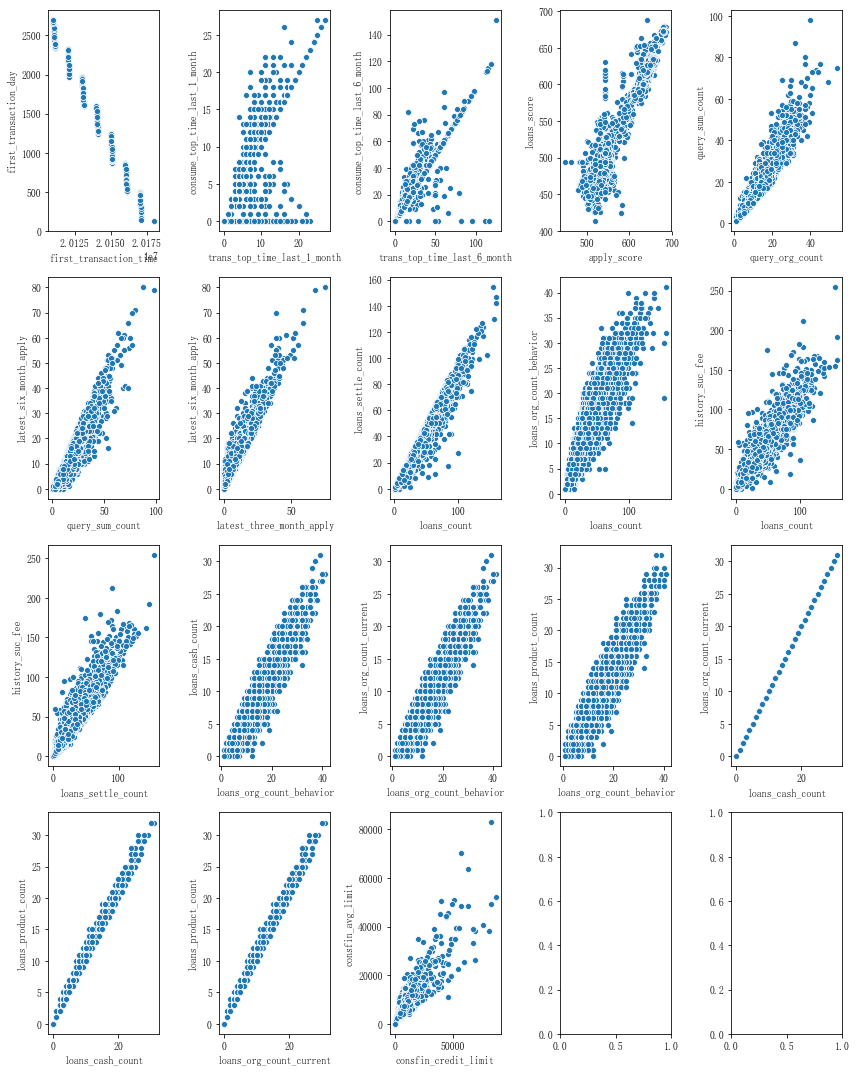

In [83]:
fig, axes = plt.subplots(4, 5, figsize=(12, 15))
axes = [j for i in axes for j in i]
for i in range(len(high_corrs)):
    scatter_corr(i, axes[i])
plt.tight_layout()

In [84]:
high_corrs097 = []
for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]):
        if corr_mat.values[i][j] >0.97 or corr_mat.values[i][j] <-0.97:
            if i != j:
                high_corrs097.append((corr_mat.index[i], corr_mat.columns[j]))

In [85]:
high_corrs097

[('first_transaction_time', 'first_transaction_day'),
 ('loans_count', 'loans_settle_count'),
 ('loans_cash_count', 'loans_org_count_current'),
 ('loans_cash_count', 'loans_product_count'),
 ('loans_org_count_current', 'loans_product_count')]

In [86]:
to_del_highcorr = ['first_transaction_day', 'apply_score',
                   'loans_settle_count', 'loans_org_count_current', 'loans_product_count']

In [87]:
train_test.drop(['loans_org_count_current', 'loans_cash_count', 'first_transaction_day', 'apply_score'], axis=1, inplace=True)

## 删除方差很小的特征

对于数值特征来说，方差小于 0.02 的特征数值几乎不发生变化，对模型没有作用

In [88]:
train_test[train_test.columns[train_test.nunique()>50]].var(0).sort_values()

middle_volume_percent                         2.097776e-02
trans_activity_day                            2.896606e-02
trans_activity_month                          3.877745e-02
latest_three_month_apply                      5.637315e+01
latest_six_month_apply                        8.294810e+01
number_of_trans_from_2011                     1.011328e+02
latest_six_month_loan                         1.157018e+02
query_sum_count                               1.223616e+02
trans_top_time_last_6_month                   1.678200e+02
consume_top_time_last_6_month                 1.720799e+02
trans_days_interval                           2.713278e+02
trans_day_last_12_month                       3.635298e+02
loans_settle_count                            4.511857e+02
trans_days_interval_filter                    5.158195e+02
loans_count                                   5.848436e+02
history_fail_fee                              6.085127e+02
history_suc_fee                               8.686704e+

In [89]:
train_test[["middle_volume_percent", 'trans_activity_day', 'trans_activity_month']].describe()

,middle_volume_percent,trans_activity_day,trans_activity_month
count,4754.000000,4754.000000,4754.000000
mean,0.901332,0.365356,0.804493
std,0.144837,0.170194,0.196920
min,0.000000,0.033000,0.120000
25%,0.880000,0.233000,0.670000
50%,0.960000,0.350000,0.860000
75%,0.990000,0.479500,1.000000
max,1.000000,0.941000,1.000000


这三个值得方差小，因为他们是小数，考虑处理一下小数情况

## 连续特征离散化

In [90]:
train_test.shape

(4754, 91)

### 处理 [0, 1] 的小数（二值化）

In [91]:
numpercent_tr_te = train_test[train_test.columns[(
    train_test.min() >= 0) & (train_test.max() <= 1)][:7]]

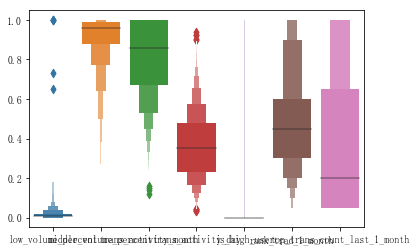

In [92]:
sns.boxenplot(data=numpercent_tr_te)

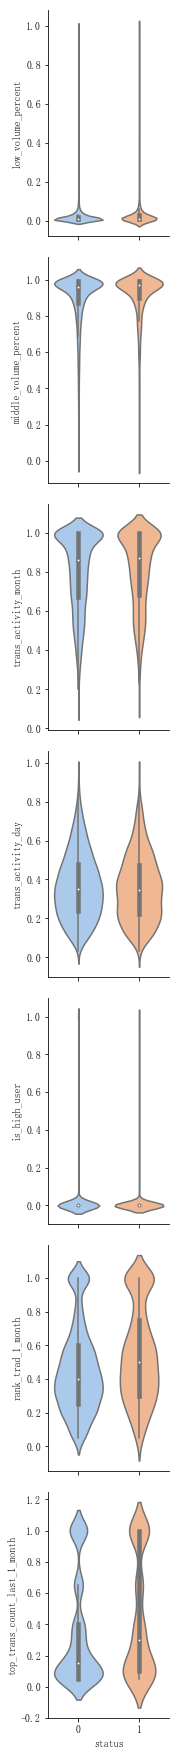

In [93]:
g = sns.PairGrid(pd.concat((numpercent_tr_te, y), axis=1),
                 x_vars=['status'],
                 y_vars=numpercent_tr_te.columns,
                 aspect=.75, height=3.5)
g.map(sns.violinplot, palette="pastel")

两个 label 下，数值分布基本是一致的。  
把小数用二值化表示，防止过拟合

In [94]:
bins=[0.02, 0.95, 0.9, 0.3, 0.4, 0.15, 0.5]

In [95]:
for i, v in enumerate(numpercent_tr_te.columns):
    numpercent_tr_te[v] = np.where(numpercent_tr_te[v]>bins[i], 1, 0)

In [96]:
train_test[numpercent_tr_te.columns] = numpercent_tr_te

### 处理整数

从与 status 最相关的几个特征入手

#### trans_fail_top_count_enum_last_1_month

主要处理思路分箱计数，违约率排名

In [97]:
train_test['trans_fail_top_count_enum_sum'] = train_test['trans_fail_top_count_enum_last_1_month'] + \
    train_test['trans_fail_top_count_enum_last_6_month'] + \
    train_test['trans_fail_top_count_enum_last_12_month']

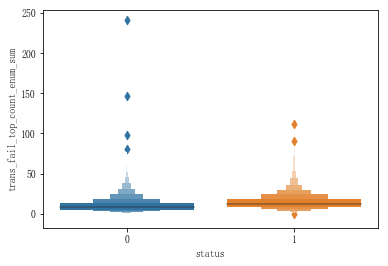

In [98]:
sns.boxenplot(data=pd.concat(
    (train_test['trans_fail_top_count_enum_sum'], y), axis=1), y='trans_fail_top_count_enum_sum', x='status')

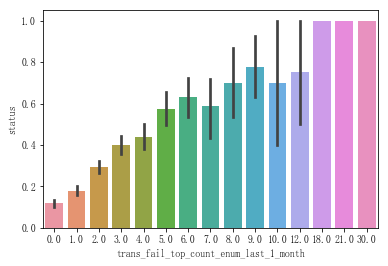

In [99]:
sns.barplot(data=pd.concat((train_test, y), axis=1), y='status', x='trans_fail_top_count_enum_last_1_month')

In [100]:
# 类别违约排名
def cat_rank(train_test, train_set, col):
    df_rank = train_set.groupby(col)['status'].mean().reset_index()
    df_rank[col + '_rank'] = df_rank['status'].rank()
    df_rank.drop('status', axis=1, inplace=True)
    train_test = pd.merge(train_test, df_rank, on=col, how='left')
    return train_test

# 类别违约率
def cat_ratio(train_test, train_set, col):
    df_ratio = train_set.groupby(col)['status'].mean().reset_index()
    df_ratio[col + '_ratio'] = df_ratio['status']
    df_ratio.drop('status', axis=1, inplace=True)
    train_test = pd.merge(train_test, df_ratio, on=col, how='left')
    return train_test

In [101]:
# 类别分箱及统计
def cat_bins_count(train_test, col, bins):
    train_test[col+'_bins'] = pd.cut(train_test[col], bins=bins, right=False, labels=[str(i) for i in bins][1:])
    train_test[col+'_bincount'] = train_test.groupby(col+'_bins')[col].transform('count')

In [102]:
bins=[0, 10, 20, 30, 40, 60, 100, 500]

In [103]:
cat_bins_count(train_test, 'trans_fail_top_count_enum_sum', bins)

In [104]:
train_test = cat_rank(train_test, pd.concat((train_test, y), axis=1), 'trans_fail_top_count_enum_sum_bins')

#### history_fail_fee

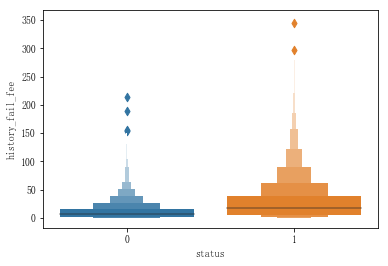

In [105]:
sns.boxenplot(data=pd.concat((train_test, y), axis=1), x='status', y='history_fail_fee')

In [106]:
pd.concat((train_test, y), axis=1)[pd.concat((train_test, y), axis=1)['history_fail_fee']>100]['status'].mean()

0.7625

In [107]:
bins = list(range(0, 100, 10)) + [500]

对 history_fail_fee 进行分箱，统计每个箱子内的个数及违约率排名

In [108]:
cat_bins_count(train_test, 'history_fail_fee', bins)

train_test = cat_rank(train_test, pd.concat((train_test, y), axis=1), 'history_fail_fee_bins')

#### loans_overdue_count

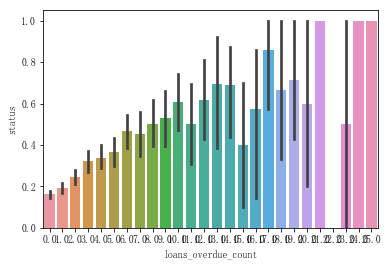

In [109]:
sns.barplot(data=pd.concat((train_test, y), axis=1), x='loans_overdue_count', y='status')

In [110]:
pd.concat((train_test, y), axis=1)[pd.concat((train_test, y), axis=1)['loans_overdue_count']>8]['status'].mean()

0.5921052631578947

In [111]:
bins = list(range(0, 11)) + [30]

In [112]:
cat_bins_count(train_test, 'loans_overdue_count', bins)

train_test = cat_rank(train_test, pd.concat((train_test, y), axis=1), 'loans_overdue_count_bins')

#### latest_one_month_fail

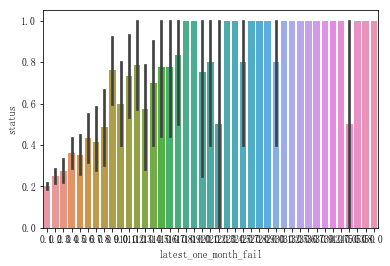

In [113]:
sns.barplot(data=pd.concat((train_test, y), axis=1), x='latest_one_month_fail', y='status')

In [114]:
pd.concat((train_test, y), axis=1)[pd.concat((train_test, y), axis=1)['latest_one_month_fail']>6]['status'].mean()

0.7276995305164319

In [115]:
bins = list(range(0, 14)) + [100]

In [116]:
cat_bins_count(train_test, 'latest_one_month_fail', bins)

train_test = cat_rank(train_test, pd.concat(
    (train_test, y), axis=1), 'latest_one_month_fail_bins')

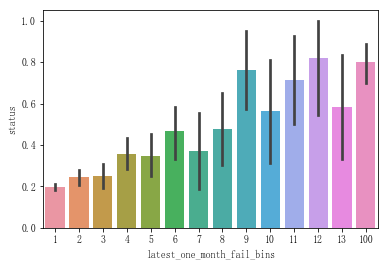

In [117]:
sns.barplot(data=pd.concat(
    (train_test[:x_train.shape[0]], y), axis=1), x='latest_one_month_fail_bins', y='status')

#### loans_score

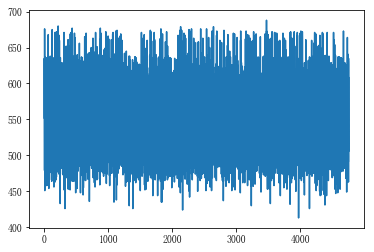

In [118]:
plt.plot(train_test['loans_score'])

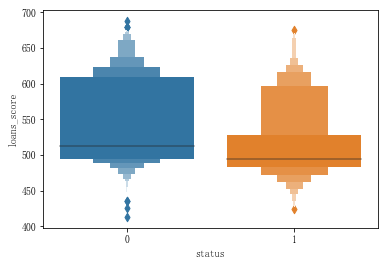

In [119]:
sns.boxenplot(data=pd.concat((train_test['loans_score'], y), axis=1), y='loans_score', x='status')

In [120]:
bins = list(range(400, 750, 50))

In [121]:
cat_bins_count(train_test, 'loans_score', bins)

In [122]:
train_test = cat_rank(train_test, pd.concat((train_test, y), axis=1)[
                      :x_train.shape[0]], 'loans_score_bins')

In [123]:
dataset05 = train_test
dataset05 = dataset05.convert_objects(convert_numeric=True)
dataset05 = minmax_scale(dataset05)
x_train, x_test, y_train, y_test = train_test_split(dataset05, y, test_size=0.2, random_state=666)
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train, y_train, x_test)

C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.80      0.98      0.88      2863
          1       0.77      0.24      0.37       940

avg / total       0.79      0.79      0.75      3803

SVC AUC：
 0.8086618708243845
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.77      0.96      0.86       698
          1       0.69      0.22      0.33       253

avg / total       0.75      0.77      0.72       951

SVC AUC：
 0.7906695584221434


# 交叉特征

## 高相关或低相关的统计量

In [124]:
corrs = pd.concat((train_test, y), axis=1).corr().loc['status'].sort_values(ascending=False)

所有 rank 的平均数，最大值
bool 特征的加和

rank 的平均数/最大值

In [125]:
ranks = ['trans_fail_top_count_enum_sum_bins_rank', 'history_fail_fee_bins_rank',
         'loans_overdue_count_bins_rank', 'latest_one_month_fail_bins_rank', 'loans_score_bins_rank']

In [126]:
train_test['corr_rank_sum'] = train_test[ranks].sum(1)
train_test['corr_rank_max'] = train_test[ranks].max(1)

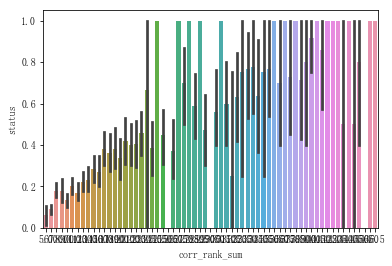

In [127]:
sns.barplot(data=pd.concat((train_test, y), axis=1), x='corr_rank_sum', y='status')

In [128]:
bincounts = ['latest_one_month_fail_bincount', 'loans_overdue_count_bincount',
            'history_fail_fee_bincount', 'trans_fail_top_count_enum_sum_bincount']

In [129]:
train_test['bin_counts_sum'] = train_test[bincounts].sum(1)

## 高相关的交叉特征

In [130]:
corr_mat = pd.concat((train_test, y)[:x_train.shape[0]], axis=1).corr()

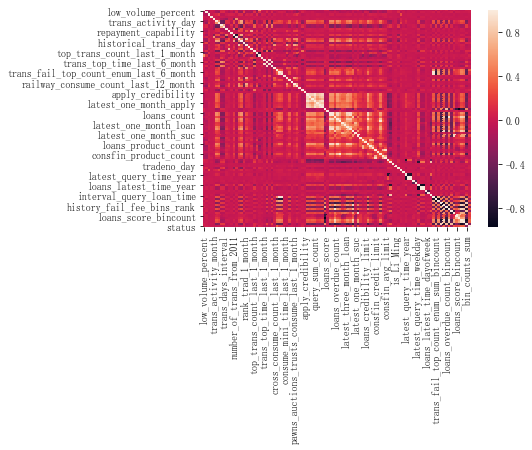

In [131]:
sns.heatmap(corr_mat)

相关系数 >0.85 的特征

In [132]:
high_corrs = []
for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]):
        if corr_mat.values[i][j] >0.85 or corr_mat.values[i][j] <-0.85:
            if i != j:
                high_corrs.append((corr_mat.index[i], corr_mat.columns[j]))

In [133]:
def scatter_corr2(idx, ax):
    c1, c2 = high_corrs[idx]
    sns.scatterplot(data=pd.concat((train_test[:x_train.shape[0]], y), axis=1), x=c1, y=c2, ax=ax, hue='status')

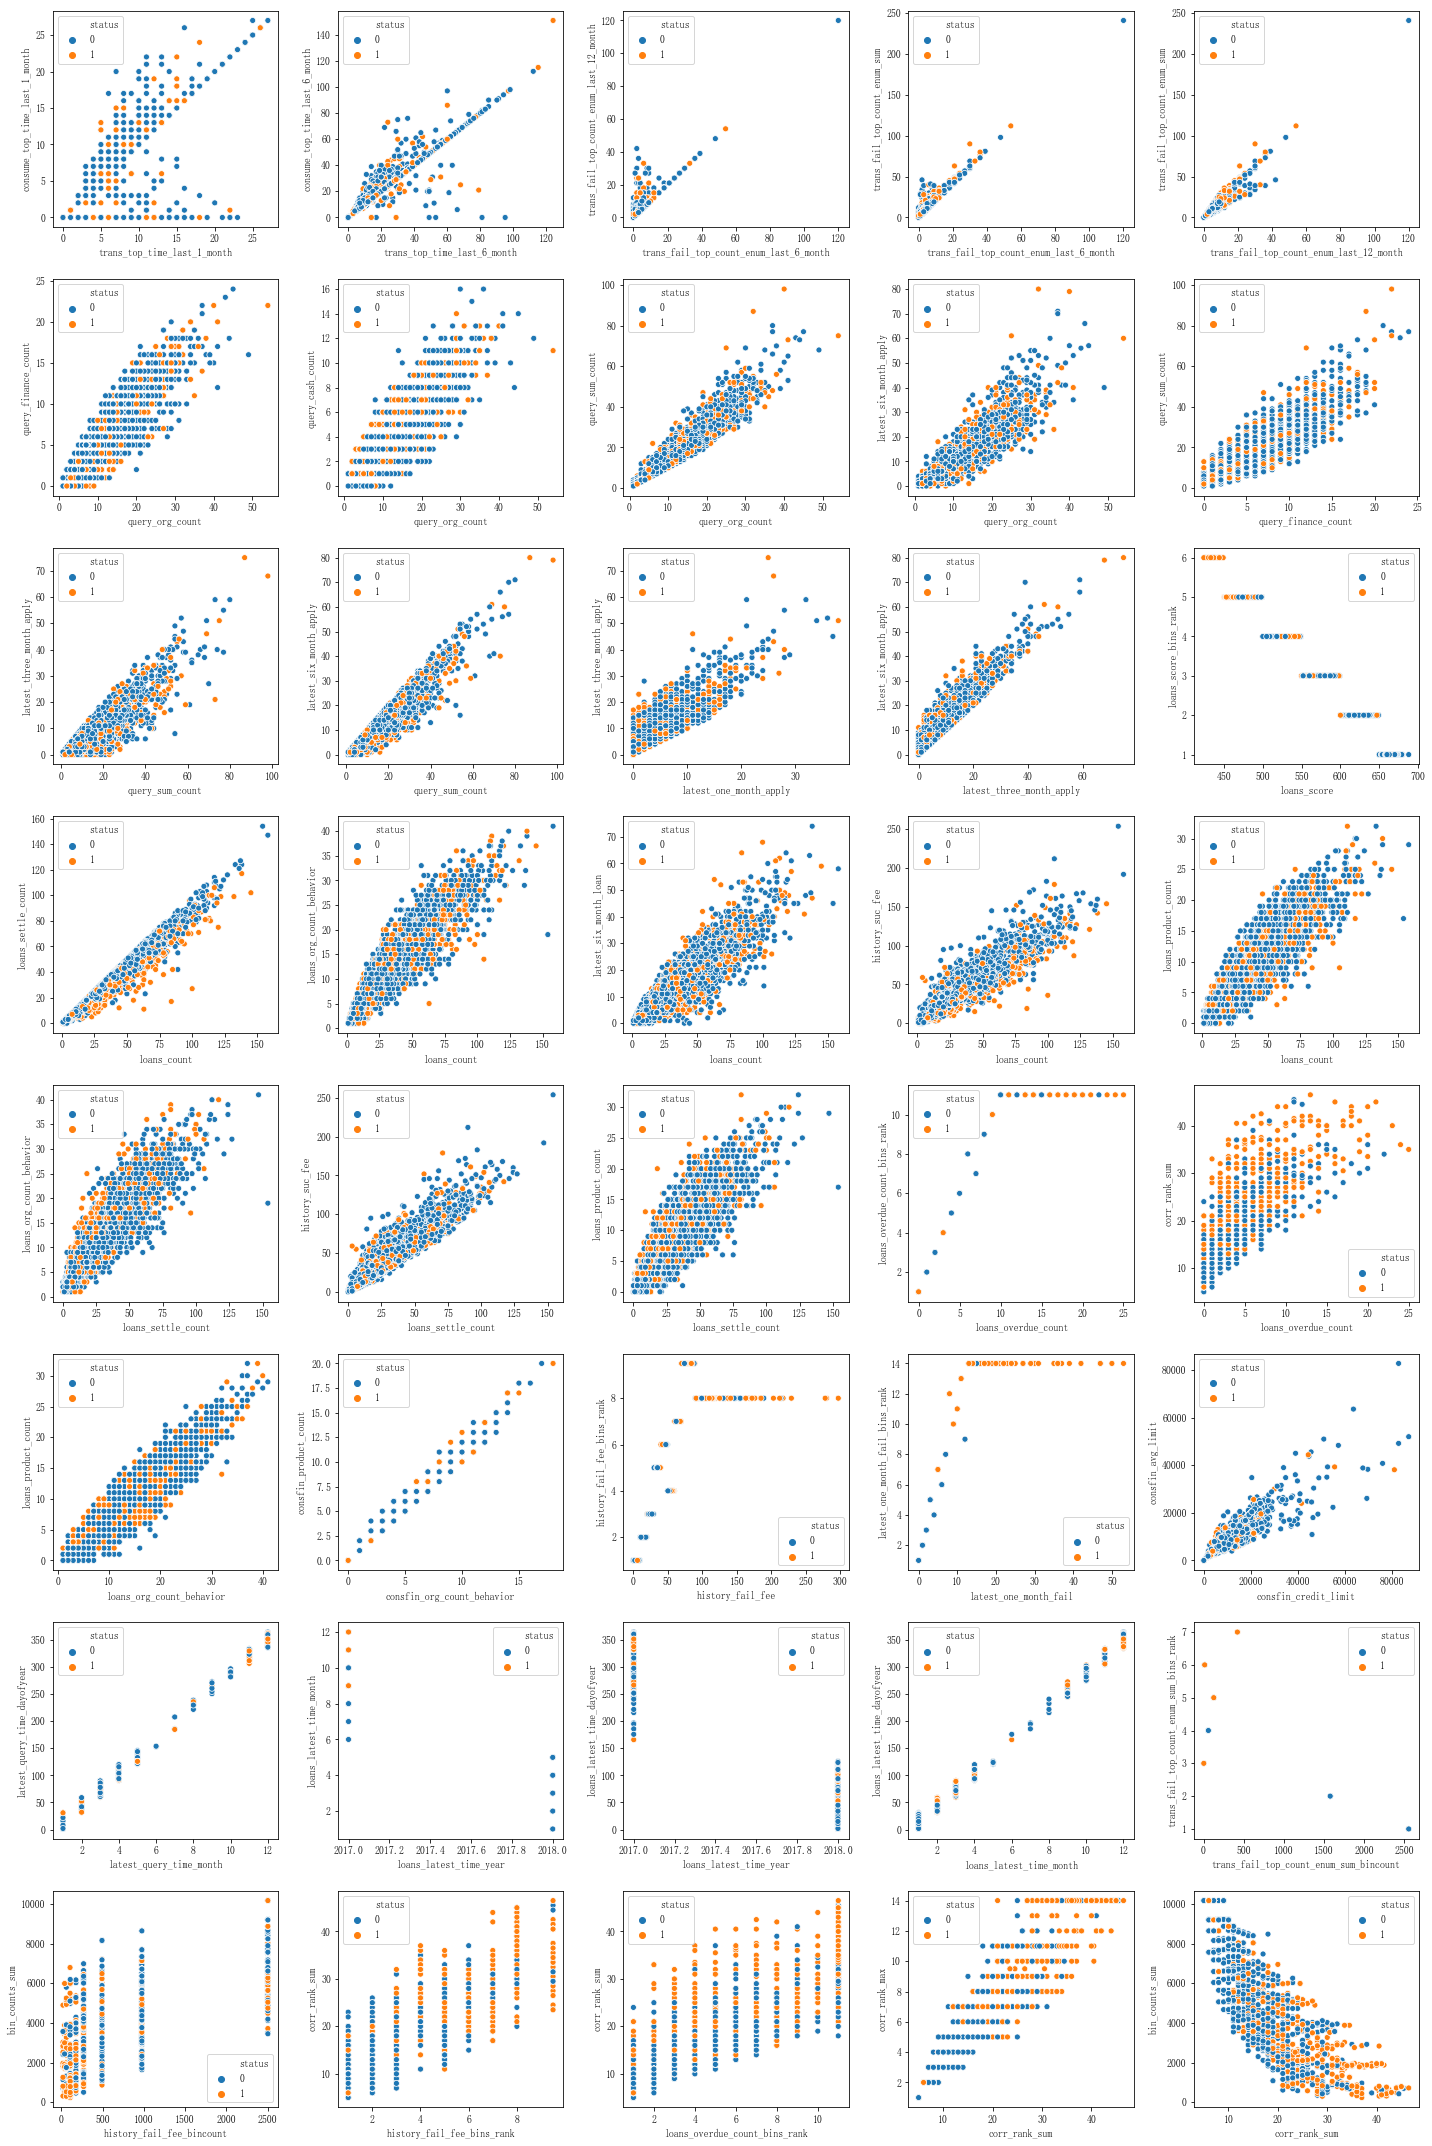

In [134]:
fig, axes = plt.subplots(8, 5, figsize=(20, 30))
axes = [j for i in axes for j in i]
for i in range(len(high_corrs)):
    scatter_corr2(i, axes[i])
plt.tight_layout()

找出 label = 1 和 0 中分布不一致的做交叉

In [135]:
cross_feat = ['trans_top_time_last_6_month/consume_top_time_last_6_month', 'trans_fail_top_count_enum_last_12_month/trans_fail_top_count_enum_last_6_month',
              'loans_settle_count/loans_count', 'history_suc_fee/loans_count', 'loans_org_count_behavior/loans_settle_count', 'loans_credit_limit+loans_avg_limit',
             'loans_overdue_count_bins/loans_overdue_count', 'loans_overdue_count_bins_rank/loans_overdue_count', 
             'latest_one_month_fail_bins/latest_one_month_fail']

In [136]:
for i in cross_feat:
    if '/' in i:
        f1, f2 = i.split('/')
        train_test[i] = train_test[f1].values.astype(
            'float') / (train_test[f2].values.astype('float')+0.001)
    elif '+' in i:
        f1, f2 = i.split('+')
        train_test[i] = train_test[f1] + train_test[f2]

In [137]:
dataset06 = train_test
dataset06 = dataset06.convert_objects(convert_numeric=True)
dataset06 = minmax_scale(dataset06)
x_train, x_test, y_train, y_test = train_test_split(dataset06, y, test_size=0.2, random_state=666)
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train, y_train, x_test)

C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.80      0.98      0.88      2863
          1       0.77      0.25      0.37       940

avg / total       0.79      0.80      0.75      3803

SVC AUC：
 0.8096904006361426
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.77      0.96      0.86       698
          1       0.67      0.22      0.33       253

avg / total       0.75      0.76      0.72       951

SVC AUC：
 0.7915161330509531


In [138]:
lgbmClassifier = LGBMClassifier()
svcmodel = SklearnWrapper(lgbmClassifier)
print_result(svcmodel, x_train, y_train, x_test)

----Training Report----
LGBMClassifier report：
              precision    recall  f1-score   support

          0       0.99      1.00      1.00      2863
          1       1.00      0.97      0.99       940

avg / total       0.99      0.99      0.99      3803

LGBMClassifier AUC：
 0.9999204821605071
----Test Report----
LGBMClassifier report：
              precision    recall  f1-score   support

          0       0.81      0.93      0.87       698
          1       0.68      0.38      0.49       253

avg / total       0.77      0.79      0.76       951

LGBMClassifier AUC：
 0.7746186167140446


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 特征重要性

利用 xgb 选择特征时，可以从特征 Gini 增益，特征分裂次数，特征所在的平均深度，特征是否被使用，特征子节点样本数量等方面考虑。  
利用 xgbfir 可以直接计算特征重要性的属性值。

In [139]:
import xgboost as xgb
xgb_cmodel = xgb.XGBClassifier().fit(train_test[:x_train.shape[0]].astype('float'), y_train)

In [140]:
xgbfir.saveXgbFI(xgb_cmodel, feature_names=train_test.columns, OutputXlsxFile='特征重要性.xlsx')

In [141]:
fi = pd.read_excel('特征重要性.xlsx')

In [142]:
selected_feats = fi.sort_values(by='Average Rank')[:60]['Interaction']

In [143]:
train_test_select = train_test[selected_feats]

# 模型预测和评估

In [144]:
train_test_select.shape

(4754, 60)

In [145]:
x_train, x_test, y_train, y_test = train_test_split(train_test_select, y, test_size=0.2, random_state=2018)

In [146]:
x_train_scale = minmax_scale(x_train)
x_test_scale = minmax_scale(x_test)

## LR

In [147]:
log_reg = LogisticRegression()
lr_model = SklearnWrapper(log_reg)
print_result(lr_model, x_train_scale, y_train, x_test_scale)

----Training Report----
LogisticRegression report：
              precision    recall  f1-score   support

          0       0.81      0.95      0.87      2844
          1       0.69      0.32      0.44       959

avg / total       0.78      0.79      0.76      3803

LogisticRegression AUC：
 0.8052424363752092
----Test Report----
LogisticRegression report：
              precision    recall  f1-score   support

          0       0.81      0.92      0.86       717
          1       0.57      0.33      0.42       234

avg / total       0.75      0.77      0.75       951

LogisticRegression AUC：
 0.7687122268712228


## 决策树

In [148]:
dtree = DecisionTreeClassifier(max_depth=6)
dtreemodel = SklearnWrapper(dtree)
print_result(dtreemodel, x_train, y_train, x_test)

----Training Report----
DecisionTreeClassifier report：
              precision    recall  f1-score   support

          0       0.84      0.95      0.89      2844
          1       0.76      0.47      0.58       959

avg / total       0.82      0.83      0.81      3803

DecisionTreeClassifier AUC：
 0.8360073124694763
----Test Report----
DecisionTreeClassifier report：
              precision    recall  f1-score   support

          0       0.81      0.90      0.85       717
          1       0.52      0.34      0.41       234

avg / total       0.74      0.76      0.74       951

DecisionTreeClassifier AUC：
 0.7061772103613109


## SVC

In [149]:
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train_scale, y_train, x_test_scale)

----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.79      0.97      0.87      2844
          1       0.74      0.25      0.38       959

avg / total       0.78      0.79      0.75      3803

SVC AUC：
 0.8098515947079192
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.80      0.95      0.87       717
          1       0.62      0.26      0.36       234

avg / total       0.75      0.78      0.74       951

SVC AUC：
 0.7700473244406298


## LightGBM

In [150]:
lgbmClassifier = LGBMClassifier()
lgbmodel = SklearnWrapper(lgbmClassifier)
print_result(lgbmodel, x_train, y_train, x_test)

----Training Report----
LGBMClassifier report：
              precision    recall  f1-score   support

          0       0.99      1.00      0.99      2844
          1       1.00      0.96      0.98       959

avg / total       0.99      0.99      0.99      3803

LGBMClassifier AUC：
 0.9998944047729043
----Test Report----
LGBMClassifier report：
              precision    recall  f1-score   support

          0       0.81      0.91      0.86       717
          1       0.57      0.36      0.44       234

avg / total       0.75      0.78      0.76       951

LGBMClassifier AUC：
 0.7459440451072251


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## XGBClassifier

In [151]:
xgbClassifier = XGBClassifier()
xgbmodel = SklearnWrapper(xgbClassifier)
print_result(xgbmodel, x_train, y_train, x_test)

----Training Report----
XGBClassifier report：
              precision    recall  f1-score   support

          0       0.85      0.97      0.90      2844
          1       0.83      0.49      0.61       959

avg / total       0.84      0.85      0.83      3803

XGBClassifier AUC：
 0.9002726410099597
----Test Report----
XGBClassifier report：
              precision    recall  f1-score   support

          0       0.82      0.92      0.87       717
          1       0.61      0.38      0.47       234

avg / total       0.77      0.79      0.77       951

XGBClassifier AUC：
 0.76379501484104


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


之前 AUC 的计算错误，把 y_pred 当作 y_pred_proba 来计算的。  
为什么最后 AUC 没有提高？